In [1]:
from functools import partial
from jax import jit, random, lax, vmap, value_and_grad, nn
from jax.tree_util import tree_map
import jax.numpy as jnp
import optax

key = random.key(42)

from icecream import ic
import matplotlib.pyplot as plt

# Perfect decoder and logical error rate estimator

In [2]:

class PSC3D:

    def __init__(
        self,
        H_syndrome: dict,
        H_logicals: dict,
    ):
        """Perfect SC3 decoder + lowest possible SC3 logical error rates"""
        def _syndrome_logicals(
            error,
        ):
            syndrome = (
                jnp.matmul(H_syndrome['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(H_syndrome['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(H_syndrome['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2
            logicals = (
                jnp.matmul(H_logicals['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(H_logicals['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(H_logicals['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2
            return syndrome, logicals
        
        def _error_to_prob(
            probability: jnp.ndarray,
            qubit_errors: jnp.ndarray,
        ):
            return probability[qubit_errors]
        
        self._error_to_prob_batch = vmap(
            _error_to_prob,
            in_axes=[0, 1],
            out_axes=1
        )
            
        all_errors_idx = jnp.zeros(shape=(4**9,9), dtype=jnp.int32) + jnp.arange(0,4**9)[:, None]
        self.all_errors = (all_errors_idx // 4**jnp.arange(0,9)) % 4
        batch_syndrome_logicals = vmap(_syndrome_logicals)
        self.all_syndrome, self.all_logicals = batch_syndrome_logicals(self.all_errors)
        self.syndrome_idx = jnp.dot(self.all_syndrome, 2**jnp.arange(0,8))
        self.logicals_idx = jnp.dot(self.all_logicals, 2**jnp.arange(0,2))

        self.deformation_transformations = jnp.array([
            [0,1,2,3], # I
            [0,2,1,3], # X-Y
            [0,1,3,2], # Y-Z
            [0,3,2,1], # X-Z
            [0,2,3,1], # X-Y-Z
            [0,3,1,2], # X-Z-Y
        ])
    
    
    def logical_error_rate(
        self,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        # Deform the noise model
        code_deformation = self.deformation_transformations[deformation]
        data_qubit_error_idx = jnp.zeros_like(code_deformation, dtype=int) + jnp.arange(0,deformation.shape[0])[:, None]
        noise_model = noise_model[(data_qubit_error_idx, code_deformation)]

        # Calculate the probabilily that we will have a given syndrome with a given logical
        likelyhood = jnp.prod(self._error_to_prob_batch(noise_model, self.all_errors), axis=1)
        record = jnp.zeros(shape=(2**8,4), dtype=jnp.float32)
        record = record.at[(self.syndrome_idx, self.logicals_idx)].add(likelyhood)

        # Rearage result acording to most likely decoding
        #    Logical error:            [0,0]     [1,0]     [0,1]     [1,1]
        rearange_lookup = jnp.array([[0,1,2,3],[1,0,3,2],[2,3,0,1],[3,2,1,0]])
        rearange = rearange_lookup[record.argmax(axis=1)]
        record_rearanged = record[(jnp.arange(0, 2**8)[:,None], rearange)]
        
        # Calculate the logical error rates
        logical_error_rates = record_rearanged.sum(axis=0)
        # Fix order from IXZY to IXYZ
        logical_error_rates = logical_error_rates[jnp.array([0,1,3,2])]
        return logical_error_rates
    

    def decode(
        self,
        syndrome: jnp.ndarray,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        # Deform the noise model
        code_deformation = self.deformation_transformations[deformation]
        data_qubit_error_idx = jnp.zeros_like(code_deformation, dtype=int) + jnp.arange(0,deformation.shape[0])[:, None]
        noise_model = noise_model[(data_qubit_error_idx, code_deformation)]

        # Find all the errors with the given syndrome
        active_syndrome_idx = jnp.dot(syndrome, 2**jnp.arange(0,8))
        possible_errors = self.all_errors[jnp.where(self.syndrome_idx == active_syndrome_idx)]

        # Calculate their likelyhood
        likelyhood = jnp.prod(self._error_to_prob_batch(noise_model, possible_errors), axis=1)
        if likelyhood.max() == 0:
            raise ValueError("There are no possible explanation of the error with the given nois model.")
        
        # Pick the most likely one as the recovery operation
        recodery = possible_errors[likelyhood.argmax()]
        return recodery
    

    def decode_batch(
        self,
        syndromes: jnp.ndarray,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        batch_decode = vmap(
            self.decode,
            in_axes=[0, None, None],
            out_axes=0
        )
        return batch_decode(syndromes, noise_model, deformation)


H_syndrome = {
    'x': jnp.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 
    'y': jnp.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]]), 
    'z': jnp.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]])
}
H_logicals = {
    'x': jnp.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 
    'y': jnp.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0]]), 
    'z': jnp.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0]])}
perfect_decoder = PSC3D(H_syndrome, H_logicals)

# Noise model
p_tot = .01
nu = 500
error_prob = [
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
]
print(error_prob)
physical_error_rates = jnp.array([1-sum(error_prob), *error_prob])
noise_model=jnp.ones(shape=(9,4))*physical_error_rates

[9.98003992015968e-06, 9.98003992015968e-06, 0.00998003992015968]


# Environment

In [11]:

class Environment():

    def __init__(
        self,
        num_qubits: int,
        decoder: PSC3D,
        noise_model: jnp.ndarray,
        deformation_actions: jnp.ndarray,
    ):
        self.num_qubits = num_qubits
        self.decoder = decoder
        self.noise_model = noise_model
        self.deformation_actions = deformation_actions
    

    def reset(
        self,
    ):
        state = jnp.zeros(shape=(self.num_qubits), dtype=jnp.int32)
        score = self.score_state(state)
        return state, score
        
    
    def score_state(
        self,
        state: jnp.ndarray,
    ):
        # Alternative
        deformation_idx = jnp.dot(jnp.array([0,0,1,2])[state], 3**jnp.arange(9))

        logical_error_rates = jnp.load("../testing/all_logical_error_rates_UD023_p01_nu500.npy", mmap_mode='r')[deformation_idx]
        # logical_error_rates = self.decoder.logical_error_rate(
        #     noise_model=self.noise_model,
        #     deformation=state
        # )
        error_rate = logical_error_rates[1:].sum() # Logical error rate for any error

        # Number of qec cycles that can be performed while maintaining above 99% logical fidelity
        num_operations = -jnp.log(.99) / error_rate
        return num_operations

    
    def update_state(
        self,
        state: jnp.ndarray,
        action_idx: int,
    ):
        qubit_idx, deformation_idx = jnp.unravel_index(
            indices=action_idx, 
            shape=(
                self.num_qubits,
                self.deformation_actions.shape[0]
            )
        )
        state = state.at[qubit_idx].set(
            self.deformation_actions[deformation_idx]
        )
        return state
    

    def reward(
        self,
        current_score: float,
        current_state: jnp.ndarray,
        action_idx: int,
    ):
        new_state = self.update_state(
            current_state,
            action_idx
        )
        new_score = self.score_state(
            new_state
        )
        reward = new_score - current_score
        return reward, new_score, new_state
    
environment = Environment(
    num_qubits=9,
    decoder=perfect_decoder,
    noise_model=noise_model,
    deformation_actions=jnp.array([0,1,2,3,4,5])
    # deformation_actions=jnp.array([0,2,3])
)


# Using random search

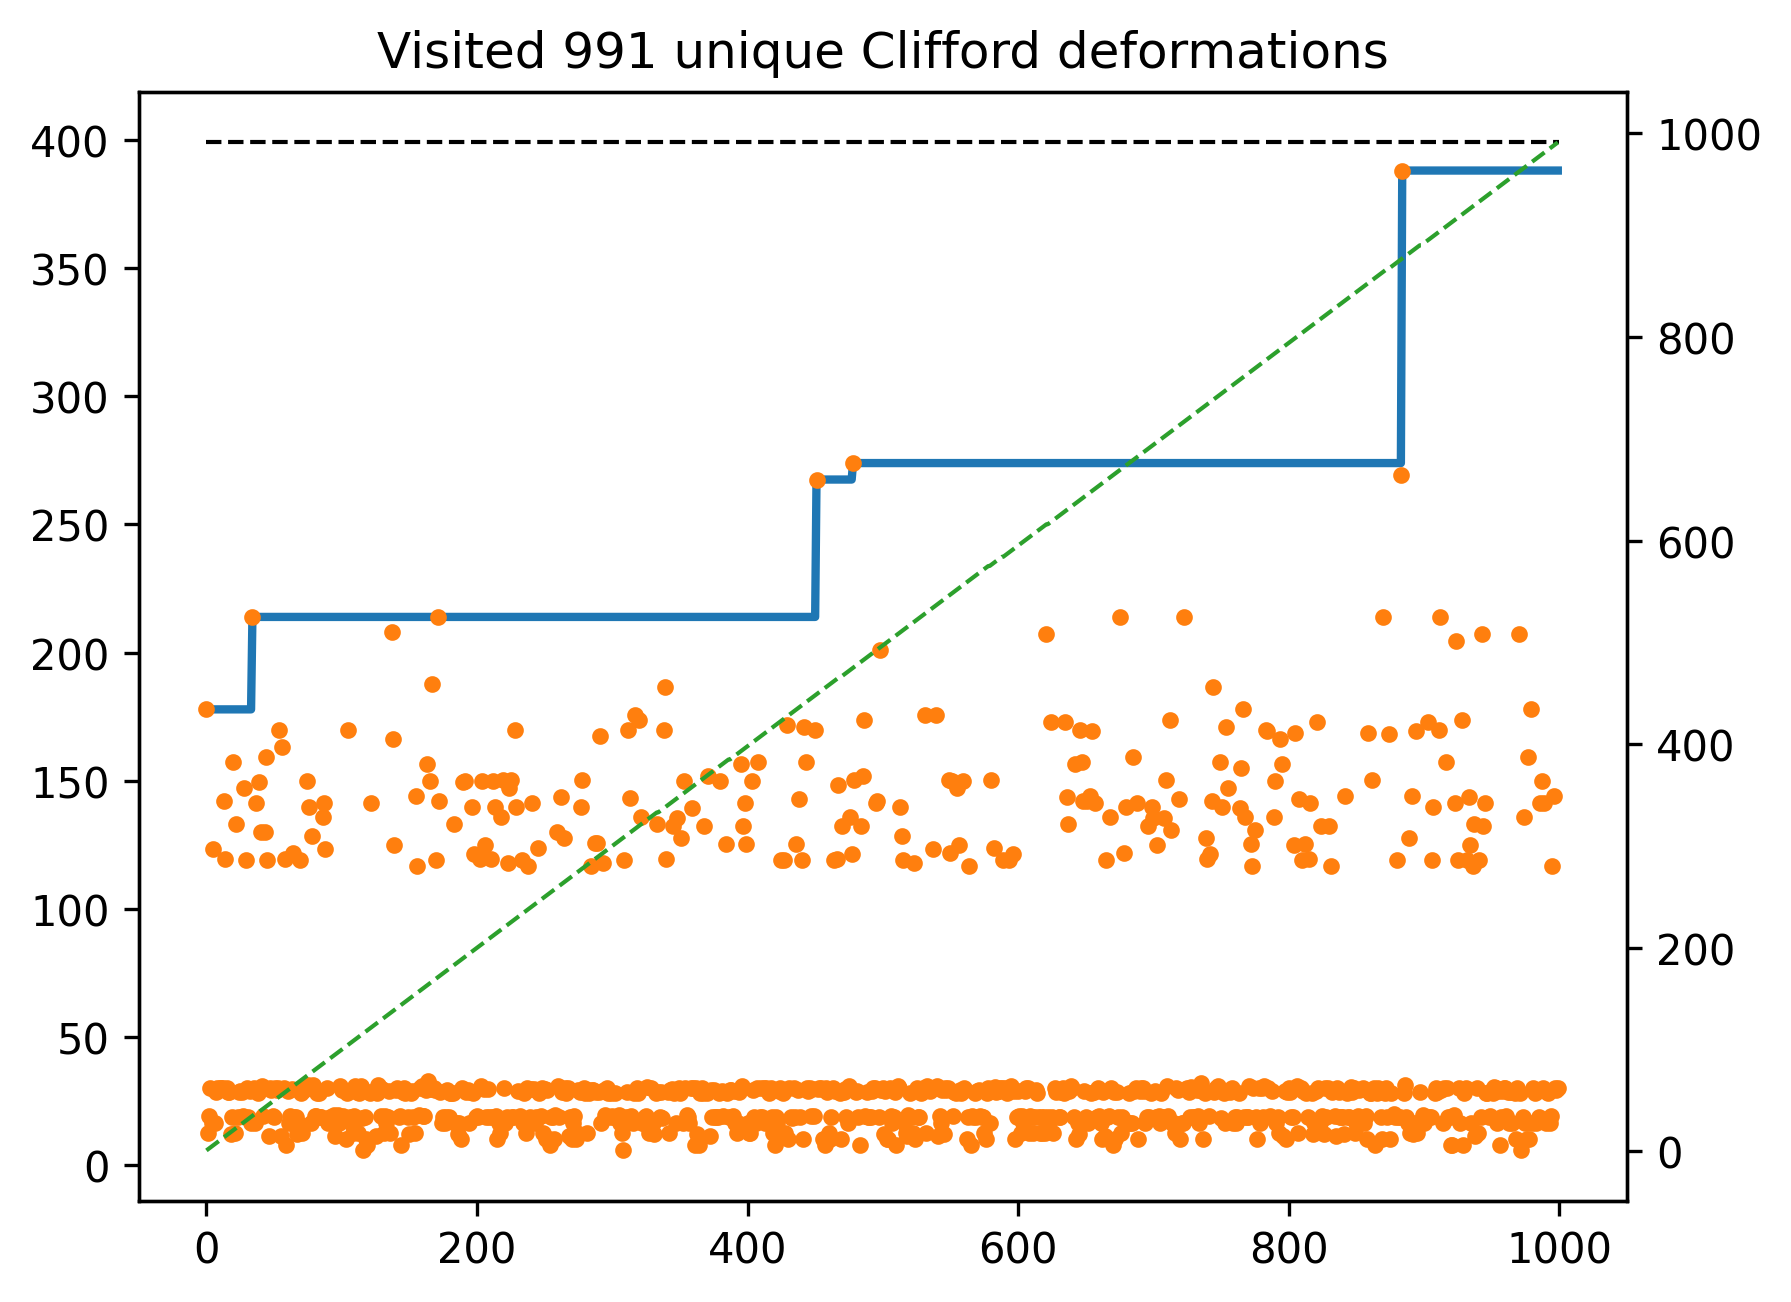

In [14]:
def random_deformation(
    key,
    deformation_actions: jnp.ndarray,
):
    deformation = deformation_actions[random.randint(key, shape=9, minval=0, maxval=deformation_actions.shape[0])]
    return deformation

deformations_visited = jnp.zeros(shape=6**9, dtype=jnp.bool)
scores = jnp.zeros(shape=1000)
running_max = jnp.zeros_like(scores)
visited = jnp.zeros_like(scores, dtype=jnp.int32)
for i in range(scores.shape[0]):
    subkey, key = random.split(key)
    state = random_deformation(key, deformation_actions=environment.deformation_actions)
    score = environment.score_state(state)

    deformation_idx = jnp.dot(state, 3**jnp.arange(9))
    # deformation_idx = jnp.dot(jnp.array([0,0,1,2])[state], 3**jnp.arange(9))
    deformations_visited = deformations_visited.at[deformation_idx].set(True)

    scores = scores.at[i].set(score)
    running_max = running_max.at[i].set(scores.max())
    visited = visited.at[i].set(deformations_visited.sum())

plt.figure(dpi=300)
plt.plot(jnp.arange(scores.shape[0]), running_max, lw=2)
plt.plot(jnp.arange(scores.shape[0]), scores, '.')
plt.hlines([398.99194], [0], [scores.shape[0]], ls='--', color='k', zorder=0, lw=1)
plt.title(f"Visited {deformations_visited.sum()} unique Clifford deformations")
plt.twinx().plot(jnp.arange(scores.shape[0]), visited, '--C2', lw=1)
plt.show()

# Using current best as jumping point

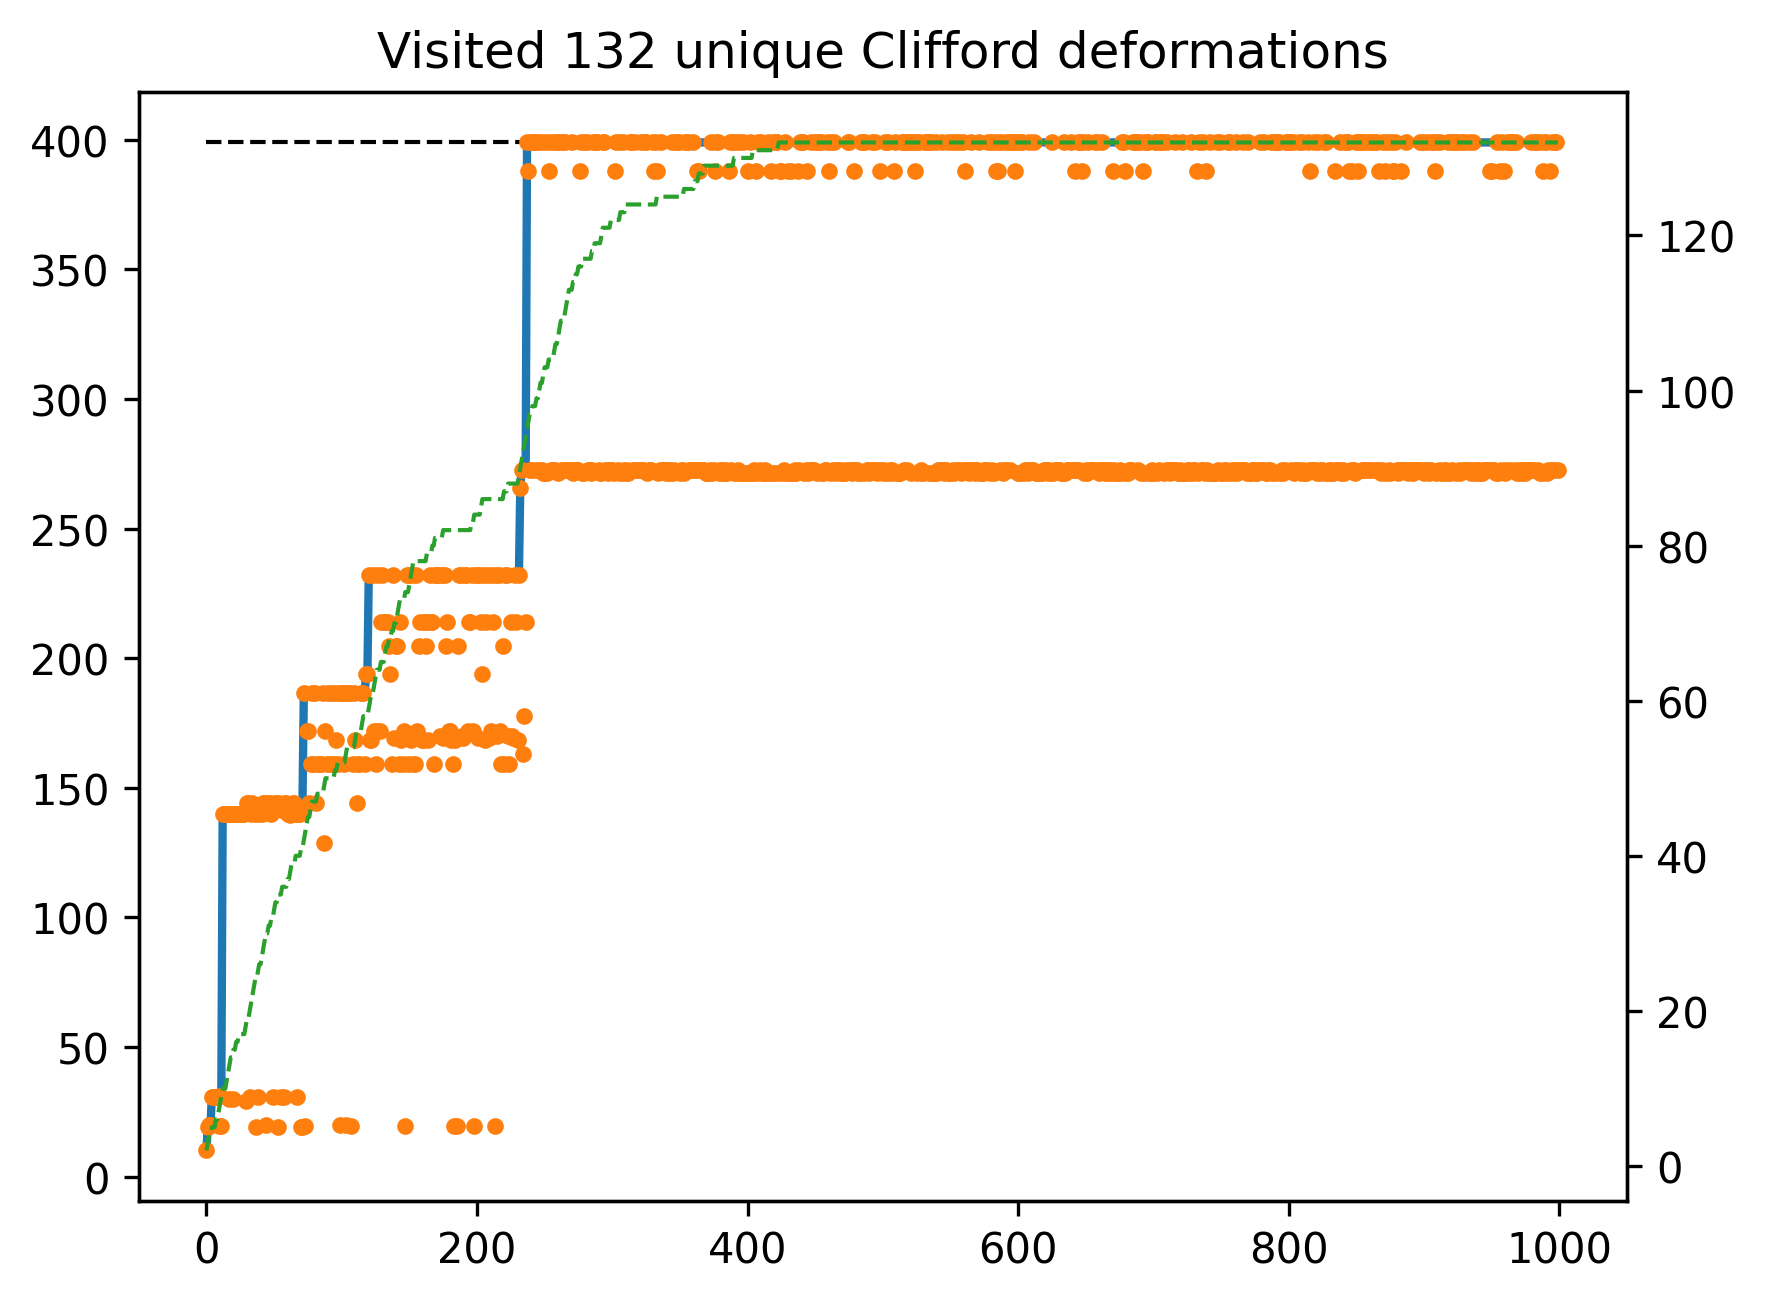

In [ ]:
state = jnp.zeros(9, dtype=jnp.int32)
score = environment.score_state(state)

deformation_idx = jnp.dot(state, 3**jnp.arange(9))
# deformation_idx = jnp.dot(jnp.array([0,0,1,2])[state], 3**jnp.arange(9))
deformations_visited = jnp.zeros(shape=6**9, dtype=jnp.bool).at[deformation_idx].set(True)

scores = jnp.zeros(shape=1000)
running_max = jnp.zeros_like(scores)
visited = jnp.zeros_like(scores, dtype=jnp.int32)
for i in range(scores.shape[0]):

    subkey, key = random.split(key)
    action = random.randint(
        key,
        shape=1,
        minval=0,
        maxval=environment.num_qubits*environment.deformation_actions.shape[0]
    )[0]
    new_state = environment.update_state(state, action)
    new_score = environment.score_state(new_state)

    deformation_idx = jnp.dot(new_state, 3**jnp.arange(9))
    # deformation_idx = jnp.dot(jnp.array([0,0,1,2])[new_state], 3**jnp.arange(9))
    deformations_visited = deformations_visited.at[deformation_idx].set(True)

    (state, score) = lax.cond(
        new_score > score,
        lambda _: (new_state, new_score),
        lambda _: (state, score),
        operand=None
    )

    scores = scores.at[i].set(new_score)
    running_max = running_max.at[i].set(scores.max())
    visited = visited.at[i].set(deformations_visited.sum())

plt.figure(dpi=300)
plt.plot(jnp.arange(scores.shape[0]), running_max, lw=2)
plt.plot(jnp.arange(scores.shape[0]), scores, '.', ms=1)
plt.hlines([398.99194], [0], [scores.shape[0]], ls='--', color='k', zorder=0, lw=1)
plt.title(f"Visited {deformations_visited.sum()} unique Clifford deformations")
plt.twinx().plot(jnp.arange(scores.shape[0]), visited, '--C2', lw=1)
plt.show()

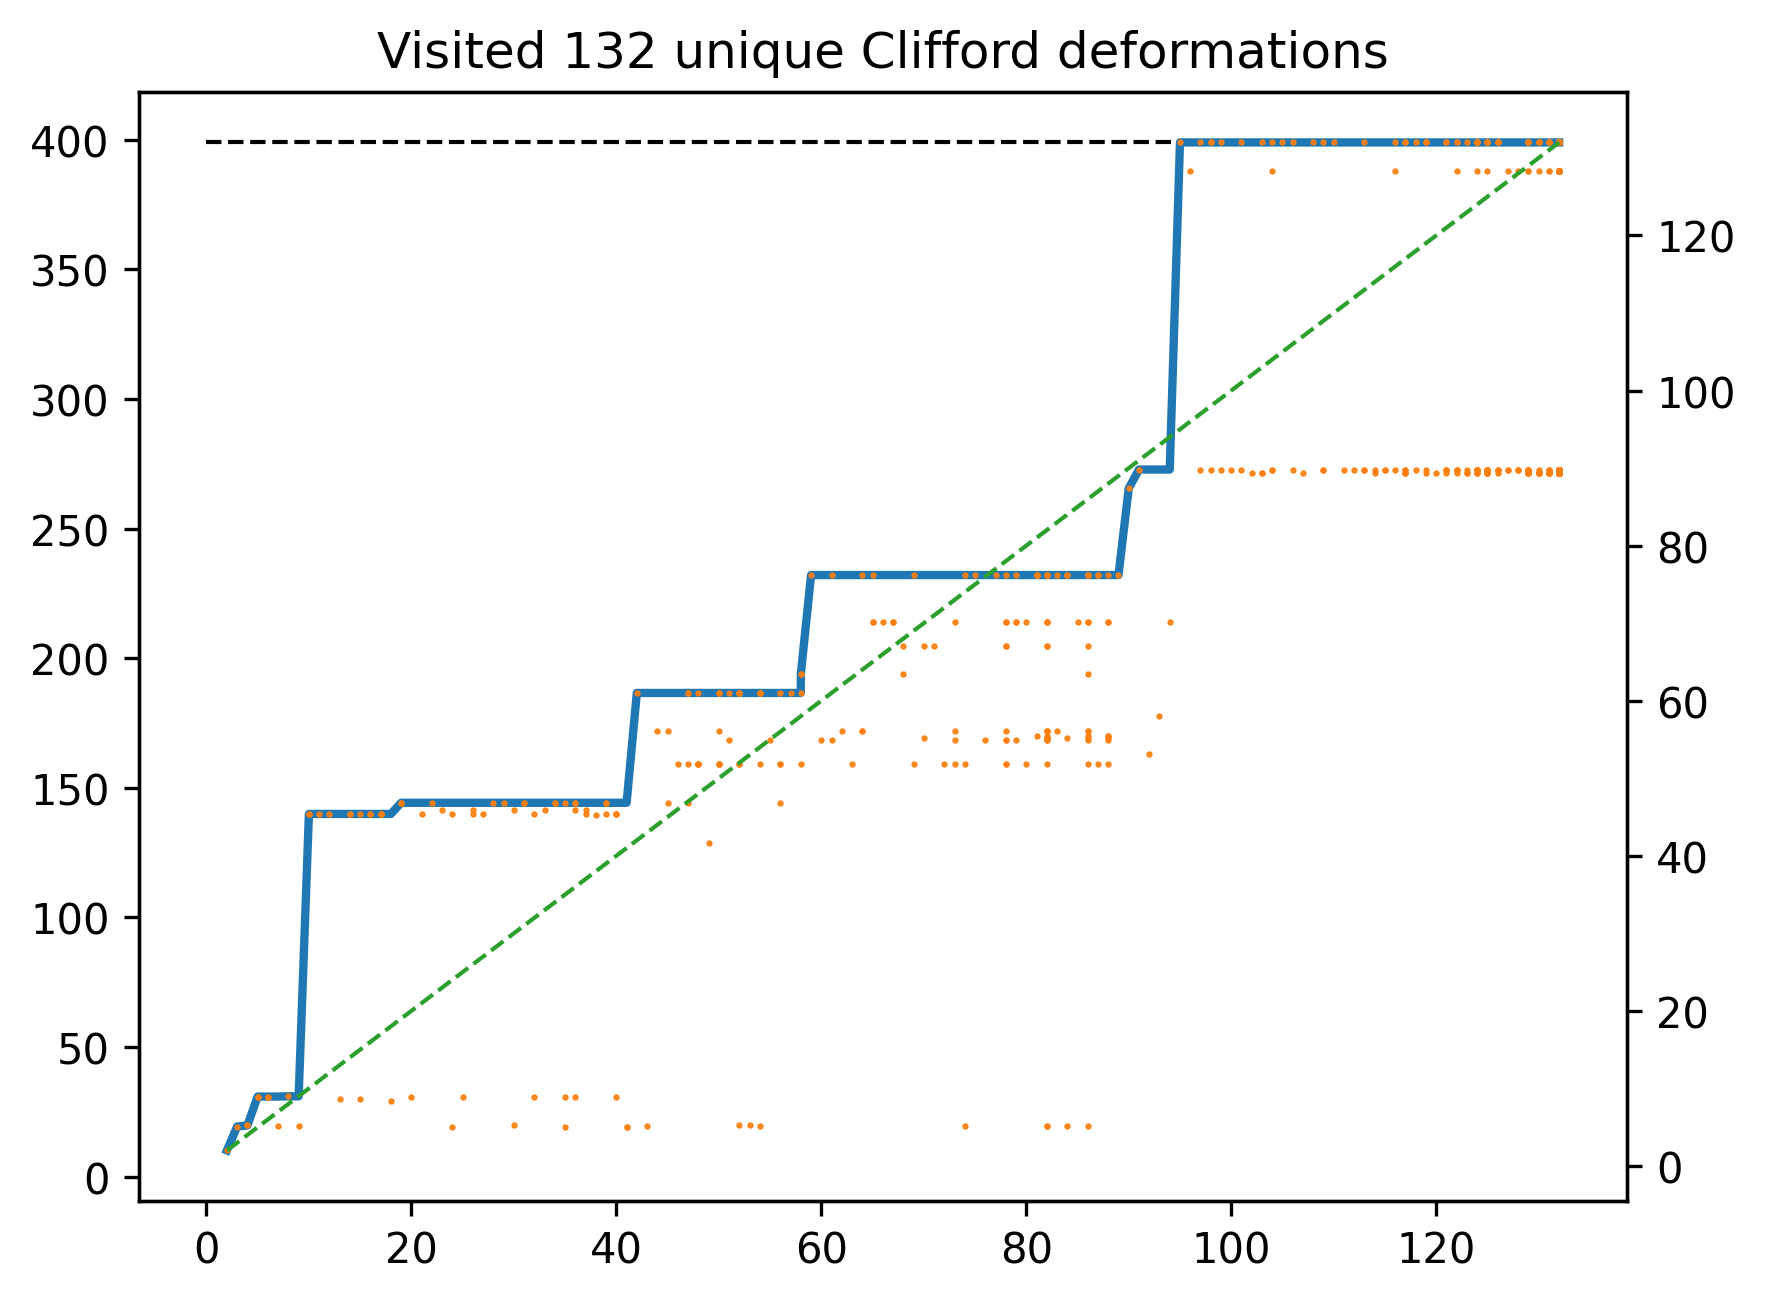

In [16]:
plt.figure(dpi=300)
plt.plot(visited, running_max, lw=2)
plt.plot(visited, scores, '.', ms=1)
plt.hlines([398.99194], [0], [visited.max()], ls='--', color='k', zorder=0, lw=1)
plt.title(f"Visited {deformations_visited.sum()} unique Clifford deformations")
plt.twinx().plot(visited, visited, '--C2', lw=1)
plt.show()